<a href="https://colab.research.google.com/github/mrMichalR/spaceship_titanic/blob/main/spaceship_titanic_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic project

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good. The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars. While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension! To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system. Help save them and change history!

In [ ]:
# !pip install opendatasets
# !pip install ydata-profiling
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import opendatasets as od
import seaborn as sns
import pandas as pd
import numpy as np
import optuna
import logging
import sys
from tqdm import tqdm
import torch
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from numpy import std, mean
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
from pandas import set_option
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import catboost as cb
from sklearn.feature_extraction import DictVectorizer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from optuna.integration import LightGBMPruningCallback, XGBoostPruningCallback, CatBoostPruningCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# %cd drive/MyDrive/spaceship_titanic/

Mounted at /content/drive


## Get data 
Get data from link: https://www.kaggle.com/competitions/spaceship-titanic/data and read to your notebook.

In [ ]:
# dataset_url = 'https://www.kaggle.com/competitions/spaceship-titanic/data'
# od.download(dataset_url)

In [ ]:

# df = pd.read_csv('/content/spaceship-titanic/train.csv')
# df

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/spaceship_titanic/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/spaceship_titanic/test.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [ ]:
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
df.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [ ]:
df[df.isnull().any(axis=1)]
df.fillna(value=np.nan, inplace=True) #just in case

In [ ]:
df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

## Data analysis

Analyze the data and perform exploratory data analysis

### Plot histograms

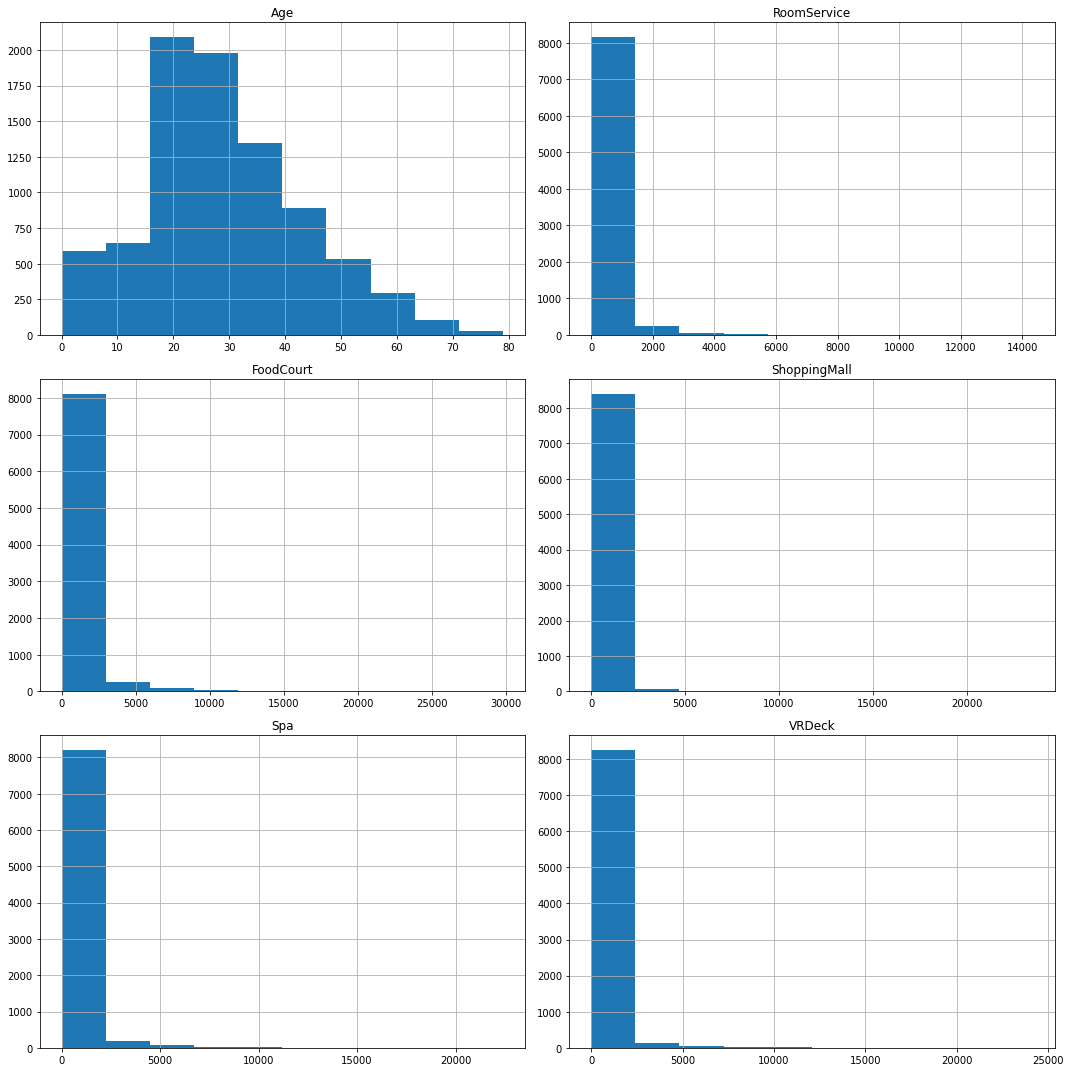

In [ ]:
# histogram
df.hist(figsize=(15,15))
plt.tight_layout()
plt.show()

### Identify correlations of data features and propose visual representation of the correlations.

In [ ]:
# correlation
# set_option('precision', 3)
df_corr = df.corr(method='pearson')
print(df_corr)

                   Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.068723   0.130421      0.033133  0.123970   
RoomService   0.068723     1.000000  -0.015889      0.054480  0.010080   
FoodCourt     0.130421    -0.015889   1.000000     -0.014228  0.221891   
ShoppingMall  0.033133     0.054480  -0.014228      1.000000  0.013879   
Spa           0.123970     0.010080   0.221891      0.013879  1.000000   
VRDeck        0.101007    -0.019581   0.227995     -0.007322  0.153821   
Transported  -0.075026    -0.244611   0.046566      0.010141 -0.221131   

                VRDeck  Transported  
Age           0.101007    -0.075026  
RoomService  -0.019581    -0.244611  
FoodCourt     0.227995     0.046566  
ShoppingMall -0.007322     0.010141  
Spa           0.153821    -0.221131  
VRDeck        1.000000    -0.207075  
Transported  -0.207075     1.000000  


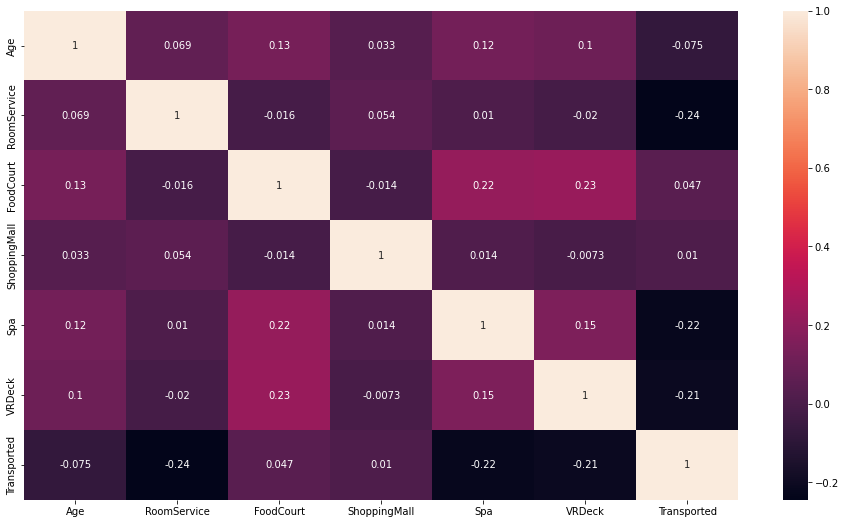

In [ ]:
# correlation visualization
plt.figure(figsize=(16,9))
sns.heatmap(df_corr, annot=True)
plt.show()

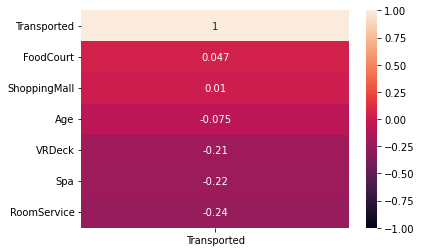

In [ ]:
heatmap = sns.heatmap(df.corr()[['Transported']].sort_values(by='Transported', ascending=False), vmin=-1, vmax=1, annot=True)

### Check if the dataset is balanced (if not think about methods to aquire balance)

In [ ]:
# target = "Transported"
df['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Target feature balanced

## Data preprocessing
Prepare data using preprocessing methods.

In [ ]:
target_name = "Transported"
X = df.drop(columns=[target_name])
y = df[target_name]
# y = df[target_name].astype(str)

In [ ]:
print(y,2*'\n')
print(X)

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool 


     PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691    

In [ ]:
X

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre


### Think and propose how represent categorical values

Proposition:
- impute or drop missing values
- encoding data with e.g. pd.replace 
- scale data

Source: https://www.youtube.com/watch?v=OGpQxIkR4ao

___
Possible simplier solution is to use pandas replace with intiger values - will be checked.
https://www.kaggle.com/code/hussainsheriff/spaceship-titanic-tensor-flow

In [ ]:
# Ordinal encoder use with encoding unknown values with -1 value

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
numerical_preprocessor = StandardScaler()
# numerical_preprocessor = MinMaxScaler()


categorical_columns= X.select_dtypes(include=object).columns.tolist()
numerical_columns = X.select_dtypes(exclude=object).columns.tolist()

In [ ]:
# Defining pipepline with prior iteration for missing values
dataset = X
categorical_pipeline = Pipeline(
    steps=[
        ("OrdEnc", categorical_preprocessor),
        ("imputer", IterativeImputer(random_state=42, skip_complete=True)),
        # ("imputer", SimpleImputer(random_state=42, missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0)),
        # ("Scaler", numerical_preprocessor),
        ])

numerical_pipeline = Pipeline(
    steps=[
        ("impute", IterativeImputer(random_state=42, skip_complete=True)),
        # ("Scaler", numerical_preprocessor),
    ]
)

In [ ]:
print(f'Before convert:\n{X.dtypes}\n')

# Convert categorical columns to Pandas category
for col in categorical_columns:
   X[col] = X[col].astype('category')

print(f'After convert:\n{X.dtypes}\n')

Before convert:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

After convert:
PassengerId     category
HomePlanet      category
CryoSleep       category
Cabin           category
Destination     category
Age              float64
VIP             category
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name            category
dtype: object



In [ ]:
# feature_names = categorical_preprocessor.get_feature_names_out()
# df_enc = pd.DataFrame(categorical_columns, columns=feature_names)
# df_enc_col=df_enc.columns.tolist()
# df_enc_col

In [ ]:
# df_enc.dtypes

In [ ]:
# df_cat = df[cat_col]
# # df_cat

# encoder=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
# df_encoded = encoder.fit_transform(df_cat)
# print(df_encoded)

# columns_encoded = encoder.get_feature_names_out(df_cat.columns)
# print(pd.DataFrame(df_encoded, columns=columns_encoded).head())

### Think and propose how to handle nulls and nan values

Proposition:
* More pro - impute (e.g. IterativeImputer) - included in above point
* The simplest approach is to remove. In this case dropping caused dataset reduction from 8693 to 6606 -> 2087 rows dropped ! -below


In [ ]:
# #Drop missing values
# X.dropna(inplace=True)
# print(f'Numeric nulls:\n{X.select_dtypes(include=np.number).isnull().sum()}\n')
# print(f'Categorical nulls:\n{X.select_dtypes(exclude=np.number).isna().sum()}\n')

# # Convert to intigers
# X=X.astype(int)
# X.isnull().sum()

### Divide dataset into train, validation and test subset

Since we have test dataset our train will be split into train and validation.

In [ ]:
# #Split of dataset to train, validation ('val') and test 
# X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.4, train_size=0.6)
# X_test, X_val, y_test, y_val = train_test_split(X_test_temp,y_test_temp, test_size = 0.5, train_size =0.5)

# print('TRAIN set:\n', 'X_train:', X_train.shape, '\n y_train: ', y_train.shape)
# print('VAL set:\n', 'X_val:', X_val.shape, '\n y_val: ', y_val.shape)
# print('TEST set:\n', 'X_test:', X_test.shape, '\n y_test: ', y_test.shape)


#Split of train to train and validation ('val') 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

print(2*'\n')
print('TRAIN set:\n', 'X_train:', X_train.shape, '\n y_train2: ', y_train.shape)
print('VAL set:\n', 'X_val:', X_val.shape, '\n y_val2: ', y_val.shape)




TRAIN set:
 X_train: (6085, 13) 
 y_train2:  (6085,)
VAL set:
 X_val: (2608, 13) 
 y_val2:  (2608,)


## Machine learning methods
Use standard ML algorithms to classify passengers.

In [ ]:
# enc_col = categorical_preprocessor.fit_transform(df[cat_col])

preprocessor = ColumnTransformer([
    ('categorical', categorical_preprocessor, categorical_columns),
    ('numerical', numerical_pipeline, numerical_columns)],  
    #remainder="passthrough"
    )

preprocessor

ColumnTransformer(transformers=[('categorical',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['PassengerId', 'HomePlanet', 'CryoSleep',
                                  'Cabin', 'Destination', 'VIP', 'Name']),
                                ('numerical',
                                 Pipeline(steps=[('impute',
                                                  IterativeImputer(random_state=42,
                                                                   skip_complete=True))]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck'])])

### Choose metrics you want to use to evaluate those models,

Accuracy by default but in thi scase recall might be more informative

In [ ]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))


model_name = []
name = []
for name, model_name in models:
  model = make_pipeline(preprocessor, model_name)
  model.fit(X_train, y_train)
  model.predict(X_val)
  print(f'{name} accuracy: {model.score(X_val, y_val)}')
  print(f'{name} recall: {recall_score(y_val, model.predict(X_val))}')
  # print(f'{name} precision: {precision_score(y_val2, model.predict(X_val2), average="macro")}')
  print(f'{name} f1_score: {f1_score(y_val, model.predict(X_val))}')
  print('\n')

XGB accuracy: 0.7618865030674846
XGB recall: 0.8716417910447761
XGB f1_score: 0.7899898545823469


LightGBM accuracy: 0.772239263803681
LightGBM recall: 0.7850746268656716
LightGBM f1_score: 0.7798369162342477


CatBoost accuracy: 0.7684049079754601
CatBoost recall: 0.7681388012618297
CatBoost f1_score: 0.7633228840125391




In [ ]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['PassengerId', 'HomePlanet',
                                                   'CryoSleep', 'Cabin',
                                                   'Destination', 'VIP',
                                                   'Name']),
                                                 ('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(random_state=42,
                                                                                    skip_complete=True))]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f3c0936aa60>)])

## PyTorch
Use PyTorch to solve following tasks.

### Implement logistic regression model

In [ ]:
# '''
# https://machinelearningmastery.com/building-a-logistic-regression-classifier-in-pytorch/
# '''

# # build custom module for logistic regression
# class LogisticRegression(torch.nn.Module):    
#     # build the constructor
#     def __init__(self, n_inputs, n_outputs):
#         super().__init__()
#         self.linear = torch.nn.Linear(n_inputs, n_outputs)
#     # make predictions
#     def forward(self, x):
#         y_pred = torch.sigmoid(self.linear(x))
#         return y_pred
 
# # instantiate the model
# n_inputs = 13 # makes a 1D vector of 784
# n_outputs = 1
# log_regr = LogisticRegression(n_inputs, n_outputs)
 
# # defining the optimizer
# optimizer = torch.optim.SGD(log_regr.parameters(), lr=0.001)
# # defining Cross-Entropy loss
# criterion = torch.nn.CrossEntropyLoss()
 
# epochs = 50
# Loss = []
# acc = []
# for epoch in range(epochs):
#     for i, (images, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = log_regr(images.view(-1, 28*28))
#         loss = criterion(outputs, labels)
#         # Loss.append(loss.item())
#         loss.backward()
#         optimizer.step()
#     Loss.append(loss.item())
#     correct = 0
#     for images, labels in test_loader:
#         outputs = log_regr(images.view(-1, 28*28))
#         _, predicted = torch.max(outputs.data, 1)
#         correct += (predicted == labels).sum()
#     accuracy = 100 * (correct.item()) / len(test_dataset)
#     acc.append(accuracy)
#     print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))
 
# plt.plot(Loss)
# plt.xlabel("no. of epochs")
# plt.ylabel("total loss")
# plt.title("Loss")
# plt.show()
 
# plt.plot(acc)
# plt.xlabel("no. of epochs")
# plt.ylabel("total accuracy")
# plt.title("Accuracy")
# plt.show()

In [ ]:
# '''
# https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be
# '''

# import seaborn as sns
# import numpy as np
# from sklearn.model_selection import train_test_split
# import matplotlib
# from tqdm import tqdm
# import torch

# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
# sns.set_style("darkgrid")

# from sklearn.datasets import make_classification
# import matplotlib.pyplot as plt

# separable = False
# while not separable:
#     samples = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
#     red = samples[0][samples[1] == 0]
#     blue = samples[0][samples[1] == 1]
#     separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])


# red_labels = np.zeros(len(red))
# blue_labels = np.ones(len(blue))

# labels = np.append(red_labels,blue_labels)
# inputs = np.concatenate((red,blue),axis=0)

# X_train, X_test, y_train,  y_test = train_test_split(
#     inputs, labels, test_size=0.33, random_state=42)

# class LogisticRegression(torch.nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(LogisticRegression, self).__init__()
#         self.linear = torch.nn.Linear(input_dim, output_dim)
        
#     def forward(self, x):
#         outputs = torch.sigmoid(self.linear(x))
#         return outputs

# epochs = 200_000
# input_dim = 2 # Two inputs x1 and x2 
# output_dim = 1 # Two possible outputs
# learning_rate = 0.01

# model = LogisticRegression(input_dim,output_dim)

# criterion = torch.nn.BCELoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
# y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

# losses = []
# losses_test = []
# Iterations = []
# iter = 0
# for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
#     x = X_train
#     labels = y_train
#     optimizer.zero_grad() # Setting our stored gradients equal to zero
#     outputs = model(X_train)
#     loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
    
#     loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
#     optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
#     iter+=1
#     if iter%10000==0:
#         # calculate Accuracy
#         with torch.no_grad():
#             # Calculating the loss and accuracy for the test dataset
#             correct_test = 0
#             total_test = 0
#             outputs_test = torch.squeeze(model(X_test))
#             loss_test = criterion(outputs_test, y_test)
            
#             predicted_test = outputs_test.round().detach().numpy()
#             total_test += y_test.size(0)
#             correct_test += np.sum(predicted_test == y_test.detach().numpy())
#             accuracy_test = 100 * correct_test/total_test
#             losses_test.append(loss_test.item())
            
#             # Calculating the loss and accuracy for the train dataset
#             total = 0
#             correct = 0
#             total += y_train.size(0)
#             correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
#             accuracy = 100 * correct/total
#             losses.append(loss.item())
#             Iterations.append(iter)
            
#             print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
#             print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")


# def model_plot(model,X,y,title):
#     parm = {}
#     b = []
#     for name, param in model.named_parameters():
#         parm[name]=param.detach().numpy()  
    
#     w = parm['linear.weight'][0]
#     b = parm['linear.bias'][0]
#     plt.scatter(X[:, 0], X[:, 1], c=y,cmap='jet')
#     u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
#     plt.plot(u, (0.5-b-w[0]*u)/w[1])
#     plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
#     plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
#     plt.xlabel(r'$\boldsymbol{x_1}$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
#     plt.ylabel(r'$\boldsymbol{x_2}$',fontsize=16)
#     plt.title(title)
#     plt.show()


# # Train Data
# model_plot(model,X_train,y_train,'Train Data')

# # Test Dataset Results
# model_plot(model,X_test,y_test,'Test Data')
# view rawLogistic_Regression_PyTorch.py hosted with ❤ by GitHub

In [ ]:
'''
https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be

part1
'''

# build custom module for logistic regression
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [ ]:
'''
https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be

part2
'''

# imputer = SimpleImputer(missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0)
# X_train_filled = imputer.fit_transform(X_train)
# X_val_filled = imputer.transform(X_val)

# preparing data for tensors
# X_train_transformed, y_train_transformed = preprocessor.fit_transform(X_train), y_train.astype(int) 
X_train_transformed  = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

X_train_transformed = pd.DataFrame(X_train_transformed.dropna(inplace=True))
X_val_transformed = X_val_transformed.dropna(inplace=True)

#Scaling data
X_train_transformed = numerical_preprocessor.fit_transform(X_train_transformed)
X_val_transformed = numerical_preprocessor.transform(X_val_transformed)
print(X_train_transformed)

# preparing tensors
X_train_tensor = torch.from_numpy(X_train_transformed.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.to_numpy().astype(np.float32))
X_val_tensor = torch.from_numpy(X_val_transformed.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.to_numpy().astype(np.float32))

#re-shape y values
y_train_tensor = y_train_tensor.view(y_train_tensor.shape[0],1)
# print(y_train_tensor.shape)
y_val_tensor = y_val_tensor.view(y_val_tensor.shape[0],1)
# print(y_val_tensor.shape)


# # build custom module for logistic regression
# class LogisticRegression(torch.nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(LogisticRegression, self).__init__()
#         self.linear = torch.nn.Linear(input_dim, output_dim)
        
#     def forward(self, x):
#         outputs = torch.sigmoid(self.linear(x))
#         return outputs

# instantiate the model
input_dim = 13 # 13 columns as input
output_dim = 1 # Two possible outputs

model_lr = LogisticRegression(input_dim,output_dim)
print(model_lr)
# defining the optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

# defining cross-entropy loss
criterion = torch.nn.BCELoss()  #Binary Cross-Entropy
# criterion = torch.nn.CrossEntropyLoss()

#training loop
epochs = 20_000
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    
    # forward pass and loss        
    outputs = model_lr(X_train_tensor)
    # loss = criterion(torch.squeeze(outputs), y_train_tensor) # [200,1] -squeeze-> [200]\
    loss = criterion(outputs, y_train_tensor)
    
    #backward 
    # Loss.append(loss.item())
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    # Updates weights and biases with the optimizer (SGD)
    optimizer.step() 
    
    # Setting our stored gradients equal to zero
    optimizer.zero_grad() 
    
    iter+=1
    if iter%1000==0:
        # calculate Accuracy
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model_lr(X_val_transformed))
            loss_test = criterion(outputs_test, y_val_transformed)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_val.size(0)
            correct_test += np.sum(predicted_test == y_val.detach().numpy())
            accuracy_val = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train_transformed.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_val}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")


AttributeError: ignored

poniżej z dnia 22.03.2023

In [ ]:
'''
https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be

part2
'''


# imputer = SimpleImputer(missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0)
# X_train_filled = imputer.fit_transform(X_train)
# X_val_filled = imputer.transform(X_val)

# preparing data for tensors
# X_train_transformed, y_train_transformed = preprocessor.fit_transform(X_train), y_train.astype(int) 
# X_train_transformed  = preprocessor.fit_transform(X_train)
# X_val_transformed = preprocessor.transform(X_val)


X_train_drop = X_train.dropna()
X_val_drop = X_val.dropna()



#Scaling data
# X_train_tf = X_train_transformed.reshape(-1, 1)
X_train_scale = numerical_preprocessor.fit_transform(X_train_drop)
X_val_scale = numerical_preprocessor.transform(X_val_drop)
print(X_train_scale)

# preparing tensors
X_train_tensor = torch.from_numpy(X_train_scale.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.to_numpy().astype(np.float32))
X_val_tensor = torch.from_numpy(X_val_scale.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.to_numpy().astype(np.float32))

#re-shape y values
y_train_tensor = y_train_tensor.view(y_train_tensor.shape[0],1)
# print(y_train_tensor.shape)
y_val_tensor = y_val_tensor.view(y_val_tensor.shape[0],1)
# print(y_val_tensor.shape)


# # build custom module for logistic regression
# class LogisticRegression(torch.nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(LogisticRegression, self).__init__()
#         self.linear = torch.nn.Linear(input_dim, output_dim)
        
#     def forward(self, x):
#         outputs = torch.sigmoid(self.linear(x))
#         return outputs

# instantiate the model
input_dim = 13 # 13 columns as input
output_dim = 1 # Two possible outputs

model_lr = LogisticRegression(input_dim,output_dim)
print(model_lr)
# defining the optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

# defining cross-entropy loss
criterion = torch.nn.BCELoss()  #Binary Cross-Entropy
# criterion = torch.nn.CrossEntropyLoss()

#training loop
epochs = 20_000
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    
    # forward pass and loss        
    outputs = model_lr(X_train_tensor)
    # loss = criterion(torch.squeeze(outputs), y_train_tensor) # [200,1] -squeeze-> [200]\
    loss = criterion(outputs, y_train_tensor)
    
    #backward 
    # Loss.append(loss.item())
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    # Updates weights and biases with the optimizer (SGD)
    optimizer.step() 
    
    # Setting our stored gradients equal to zero
    optimizer.zero_grad() 
    
    iter+=1
    if iter%1000==0:
        # calculate Accuracy
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model_lr(X_val_transformed))
            loss_test = criterion(outputs_test, y_val_transformed)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_val.size(0)
            correct_test += np.sum(predicted_test == y_val.detach().numpy())
            accuracy_val = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train_transformed.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_val}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")



### Use k-fold technique to entry dataset division